In [1]:
!pip install ninja torch
import os
import shutil
import torch

torch.cuda.empty_cache()

print(f"CUDA available: {torch.cuda.get_device_name(0)}, PyTorch: {torch.__version__}")
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'  # for Tesla T4 or 1650ti (Turing)

CUDA available: Tesla T4, PyTorch: 2.8.0+cu126


In [2]:
%%writefile flash_attention_kernel.cu
#include <torch/extension.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <float.h>

#define BLOCK_SIZE_Q 16  // Br in paper
#define BLOCK_SIZE_KV 16 // Bc in paper
#define MAX_HEAD_DIM 128
#define WARP_SIZE 32

// algo v1 from Flash Attention paper https://arxiv.org/pdf/2205.14135
// Uses single-pass with online softmax computation
__global__ void flash_attention_v1_kernel(
    const float* __restrict__ Q,
    const float* __restrict__ K,
    const float* __restrict__ V,
    float* __restrict__ O,
    float* __restrict__ L,  // store row sums for backward pass
    int batch_size,
    int num_heads,
    int seq_len,
    int head_dim,
    float scale
) {
    // thread block processes Br rows of Q
    const int batch_idx = blockIdx.z;
    const int head_idx = blockIdx.y;
    const int q_block_idx = blockIdx.x;

    const int q_start = q_block_idx * BLOCK_SIZE_Q;
    if (q_start >= seq_len) return;
    const int q_end = min(q_start + BLOCK_SIZE_Q, seq_len);

    // shared memory for Q, K, V blocks
    extern __shared__ float smem[];
    float* Q_shared = smem;  // [BLOCK_SIZE_Q][head_dim]
    float* K_shared = &smem[BLOCK_SIZE_Q * head_dim];  // [BLOCK_SIZE_KV][head_dim]
    float* V_shared = &smem[BLOCK_SIZE_Q * head_dim + BLOCK_SIZE_KV * head_dim];  // [BLOCK_SIZE_KV][head_dim]

    const int tid = threadIdx.x;
    const int qkv_base = batch_idx * num_heads * seq_len * head_dim +
                         head_idx * seq_len * head_dim;

    // load Q block into shared memory (lines 4-5 in algo v1)
    for (int i = tid; i < (q_end - q_start) * head_dim; i += blockDim.x) {
        int q_idx = i / head_dim;
        int d = i % head_dim;
        Q_shared[q_idx * head_dim + d] = Q[qkv_base + (q_start + q_idx) * head_dim + d];
    }
    __syncthreads();

    // each thread handles one query
    const int q_local = tid;
    if (q_local >= (q_end - q_start)) return;

    // init online softmax variables (line 7 in algo v1)
    float m_i = -FLT_MAX;  // Running max
    float l_i = 0.0f;      // Running sum of exp
    float O_local[MAX_HEAD_DIM] = {0};  // Output accumulator

    // main loop over K,V blocks (lines 8-16 in algo v1)
    for (int kv_start = 0; kv_start < seq_len; kv_start += BLOCK_SIZE_KV) {
        int kv_end = min(kv_start + BLOCK_SIZE_KV, seq_len);
        int kv_size = kv_end - kv_start;

        // cooperatively load K,V tiles (lines 9-10 in algo v1)
        __syncthreads();
        for (int i = tid; i < kv_size * head_dim; i += blockDim.x) {
            int kv_idx = i / head_dim;
            int d = i % head_dim;
            K_shared[kv_idx * head_dim + d] = K[qkv_base + (kv_start + kv_idx) * head_dim + d];
            V_shared[kv_idx * head_dim + d] = V[qkv_base + (kv_start + kv_idx) * head_dim + d];
        }
        __syncthreads();

        // compute S = Q @ K^T for this block (line 11 in algo v1)
        float S_block[BLOCK_SIZE_KV];
        for (int kv_idx = 0; kv_idx < kv_size; kv_idx++) {
            float score = 0.0f;
            for (int d = 0; d < head_dim; d++) {
                score += Q_shared[q_local * head_dim + d] * K_shared[kv_idx * head_dim + d];
            }
            S_block[kv_idx] = score * scale;
        }

        // online softmax update (lines 12-13 in algo v1)
        float m_i_new = m_i;
        for (int kv_idx = 0; kv_idx < kv_size; kv_idx++) {
            m_i_new = fmaxf(m_i_new, S_block[kv_idx]);
        }

        // compute P̃ = exp(S - m_new) and update statistics (lines 14-15)
        float P_tilde[BLOCK_SIZE_KV];
        float l_i_new = l_i * expf(m_i - m_i_new);  // Rescale previous sum

        for (int kv_idx = 0; kv_idx < kv_size; kv_idx++) {
            P_tilde[kv_idx] = expf(S_block[kv_idx] - m_i_new);
            l_i_new += P_tilde[kv_idx];
        }

        // rescale output accumulator and add new contribution (line 16)
        float rescale = expf(m_i - m_i_new);
        for (int d = 0; d < head_dim; d++) {
            O_local[d] = O_local[d] * rescale;
            for (int kv_idx = 0; kv_idx < kv_size; kv_idx++) {
                O_local[d] += P_tilde[kv_idx] * V_shared[kv_idx * head_dim + d];
            }
        }

        // update running statistics
        m_i = m_i_new;
        l_i = l_i_new;
    }

    // write final output O = O / l (line 17 in algo v1)
    int global_q_idx = q_start + q_local;
    if (global_q_idx < seq_len) {
        int out_offset = qkv_base + global_q_idx * head_dim;
        for (int d = 0; d < head_dim; d++) {
            O[out_offset + d] = O_local[d] / l_i;
        }
        // store l_i for potential backward pass
        if (L != nullptr) {
            L[batch_idx * num_heads * seq_len + head_idx * seq_len + global_q_idx] = l_i;
        }
    }
}


// optimized kernel with warp-level primitives
__device__ __forceinline__ float warpReduceSum(float val) {
    for (int offset = WARP_SIZE/2; offset > 0; offset /= 2) {
        val += __shfl_xor_sync(0xffffffff, val, offset);
    }
    return val;
}
__device__ __forceinline__ float warpReduceMax(float val) {
    for (int offset = WARP_SIZE/2; offset > 0; offset /= 2) {
        val = fmaxf(val, __shfl_xor_sync(0xffffffff, val, offset));
    }
    return val;
}

// vectorized memory access version
__global__ void flash_attention_v1_vectorized(
    const float* __restrict__ Q,
    const float* __restrict__ K,
    const float* __restrict__ V,
    float* __restrict__ O,
    int batch_size,
    int num_heads,
    int seq_len,
    int head_dim,
    float scale
) {
    const int tid = threadIdx.x;
    const int warp_id = tid / WARP_SIZE;
    const int lane_id = tid % WARP_SIZE;

    // block processes multiple queries
    const int batch_idx = blockIdx.z;
    const int head_idx = blockIdx.y;
    const int q_block_idx = blockIdx.x;

    const int q_start = q_block_idx * BLOCK_SIZE_Q;
    if (q_start >= seq_len) return;

    extern __shared__ float smem[];
    float* Q_shared = smem;
    float* K_shared = &smem[BLOCK_SIZE_Q * MAX_HEAD_DIM];
    float* V_shared = &smem[BLOCK_SIZE_Q * MAX_HEAD_DIM + BLOCK_SIZE_KV * MAX_HEAD_DIM];

    const int qkv_base = batch_idx * num_heads * seq_len * head_dim +
                         head_idx * seq_len * head_dim;

    // load Q with float4 for coalesced access
    const int q_size = min(BLOCK_SIZE_Q, seq_len - q_start);
    for (int i = tid; i < q_size * head_dim; i += blockDim.x) {
        int q_idx = i / head_dim;
        int d = i % head_dim;
        Q_shared[q_idx * MAX_HEAD_DIM + d] = Q[qkv_base + (q_start + q_idx) * head_dim + d];
    }
    __syncthreads();

    // proc queries with warp-level parallelism
    for (int q_local = warp_id; q_local < q_size; q_local += (blockDim.x / WARP_SIZE)) {
        float m = -FLT_MAX;
        float l = 0.0f;
        float acc[4] = {0};  // Process 4 elements per thread

        for (int kv_start = 0; kv_start < seq_len; kv_start += BLOCK_SIZE_KV) {
            __syncthreads();

            // load K,V tiles
            int kv_size = min(BLOCK_SIZE_KV, seq_len - kv_start);
            for (int i = tid; i < kv_size * head_dim; i += blockDim.x) {
                int kv_idx = i / head_dim;
                int d = i % head_dim;
                K_shared[kv_idx * MAX_HEAD_DIM + d] = K[qkv_base + (kv_start + kv_idx) * head_dim + d];
                V_shared[kv_idx * MAX_HEAD_DIM + d] = V[qkv_base + (kv_start + kv_idx) * head_dim + d];
            }
            __syncthreads();

            // compute scores with warp reduction
            float scores[BLOCK_SIZE_KV];
            for (int kv_idx = 0; kv_idx < kv_size; kv_idx++) {
                float score = 0.0f;
                for (int d = lane_id; d < head_dim; d += WARP_SIZE) {
                    score += Q_shared[q_local * MAX_HEAD_DIM + d] *
                            K_shared[kv_idx * MAX_HEAD_DIM + d];
                }
                score = warpReduceSum(score);
                if (lane_id == 0) scores[kv_idx] = score * scale;
            }

            // broadcast scores to all lanes
            for (int kv_idx = 0; kv_idx < kv_size; kv_idx++) {
                scores[kv_idx] = __shfl_sync(0xffffffff, scores[kv_idx], 0);
            }

            // online softmax
            float m_new = m;
            for (int kv_idx = 0; kv_idx < kv_size; kv_idx++) {
                m_new = fmaxf(m_new, scores[kv_idx]);
            }

            float rescale = expf(m - m_new);
            l *= rescale;
            for (int i = 0; i < 4; i++) acc[i] *= rescale;

            // accumulate
            for (int kv_idx = 0; kv_idx < kv_size; kv_idx++) {
                float p = expf(scores[kv_idx] - m_new);
                l += p;

                int d_start = lane_id * 4;
                if (d_start < head_dim) {
                    for (int i = 0; i < 4 && d_start + i < head_dim; i++) {
                        acc[i] += p * V_shared[kv_idx * MAX_HEAD_DIM + d_start + i];
                    }
                }
            }

            m = m_new;
        }

        // transfer output
        int global_q = q_start + q_local;
        if (global_q < seq_len) {
            int d_start = lane_id * 4;
            if (d_start < head_dim) {
                for (int i = 0; i < 4 && d_start + i < head_dim; i++) {
                    O[qkv_base + global_q * head_dim + d_start + i] = acc[i] / l;
                }
            }
        }
    }
}

extern "C" {
    torch::Tensor flash_attention_forward_cuda(
        torch::Tensor Q,
        torch::Tensor K,
        torch::Tensor V,
        bool use_vectorized = true
    ) {
        const int batch_size = Q.size(0);
        const int num_heads = Q.size(1);
        const int seq_len = Q.size(2);
        const int head_dim = Q.size(3);

        TORCH_CHECK(head_dim <= MAX_HEAD_DIM, "head_dim exceeds MAX_HEAD_DIM");

        auto O = torch::zeros_like(Q);
        const float scale = 1.0f / sqrtf(static_cast<float>(head_dim));

        dim3 grid((seq_len + BLOCK_SIZE_Q - 1) / BLOCK_SIZE_Q, num_heads, batch_size);

        size_t smem_size = (BLOCK_SIZE_Q + 2 * BLOCK_SIZE_KV) * MAX_HEAD_DIM * sizeof(float);

        if (use_vectorized && head_dim % 4 == 0) {
            dim3 block(256);  // multiple warps
            flash_attention_v1_vectorized<<<grid, block, smem_size>>>(
                Q.data_ptr<float>(),
                K.data_ptr<float>(),
                V.data_ptr<float>(),
                O.data_ptr<float>(),
                batch_size, num_heads, seq_len, head_dim, scale
            );
        } else {
            dim3 block(BLOCK_SIZE_Q);  // one thread per query
            flash_attention_v1_kernel<<<grid, block, smem_size>>>(
                Q.data_ptr<float>(),
                K.data_ptr<float>(),
                V.data_ptr<float>(),
                O.data_ptr<float>(),
                nullptr,  // L not needed for forward only
                batch_size, num_heads, seq_len, head_dim, scale
            );
        }

        cudaError_t err = cudaGetLastError();
        TORCH_CHECK(err == cudaSuccess, "CUDA kernel error: ", cudaGetErrorString(err));

        return O;
    }
}

Overwriting flash_attention_kernel.cu


In [3]:
%%writefile flash_attention_kernel.cpp
#include <torch/extension.h>
#include <pybind11/pybind11.h>

namespace py = pybind11;

extern "C" {
    torch::Tensor flash_attention_forward_cuda(
        torch::Tensor Q,
        torch::Tensor K,
        torch::Tensor V,
        bool use_optimized
    );
}

torch::Tensor flash_attention_forward(
    torch::Tensor Q,
    torch::Tensor K,
    torch::Tensor V,
    bool use_optimized = true
) {
    // val checks
    TORCH_CHECK(Q.is_cuda(), "Q must be a CUDA tensor");
    TORCH_CHECK(K.is_cuda(), "K must be a CUDA tensor");
    TORCH_CHECK(V.is_cuda(), "V must be a CUDA tensor");
    TORCH_CHECK(Q.dtype() == torch::kFloat32, "Q must be float32");
    TORCH_CHECK(K.dtype() == torch::kFloat32, "K must be float32");
    TORCH_CHECK(V.dtype() == torch::kFloat32, "V must be float32");
    TORCH_CHECK(Q.dim() == 4, "Q must be 4-dimensional [batch, heads, seq, dim]");
    TORCH_CHECK(K.dim() == 4, "K must be 4-dimensional [batch, heads, seq, dim]");
    TORCH_CHECK(V.dim() == 4, "V must be 4-dimensional [batch, heads, seq, dim]");
    TORCH_CHECK(Q.size(0) == K.size(0) && K.size(0) == V.size(0),
                "Batch sizes must match");
    TORCH_CHECK(Q.size(1) == K.size(1) && K.size(1) == V.size(1),
                "Number of heads must match");
    TORCH_CHECK(Q.size(2) == K.size(2), "Q and K sequence lengths must match");
    TORCH_CHECK(K.size(2) == V.size(2), "K and V sequence lengths must match");
    TORCH_CHECK(Q.size(3) == K.size(3), "Q and K head dimensions must match");
    TORCH_CHECK(Q.size(3) == V.size(3), "Q and V head dimensions must match");
    TORCH_CHECK(Q.size(3) <= 128, "Head dimension must be <= 128");

    // ensure tensors are contiguous
    Q = Q.contiguous();
    K = K.contiguous();
    V = V.contiguous();

    return flash_attention_forward_cuda(Q, K, V, use_optimized);
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def(
        "flash_attention_forward",
        &flash_attention_forward,
        "Flash Attention forward pass (CUDA)",
        py::arg("Q"),
        py::arg("K"),
        py::arg("V"),
        py::arg("use_optimized") = true
    );
}

Overwriting flash_attention_kernel.cpp


In [4]:
%%writefile flash_attention.py
import torch
import math
import time
from torch.utils.cpp_extension import load

def load_kernel():
    print("compiling CUDA kernel... (this may take 30-60 seconds)")
    flash_attention_cuda = load(
        name='flash_attention_cuda',
        sources=['flash_attention_kernel.cpp', 'flash_attention_kernel.cu'],
        verbose=True,
        extra_cuda_cflags=['-O3', '-use_fast_math', '--expt-relaxed-constexpr'],
        extra_cflags=['-O3'],
    )
    print("CUDA kernel compiled successfully!")
    return flash_attention_cuda

class FlashAttention(torch.nn.Module):
    def __init__(self, cuda_module, use_optimized=True):
        super().__init__()
        self.cuda_module = cuda_module
        self.use_optimized = use_optimized

    def forward(self, Q, K, V):
        assert Q.is_cuda, "inputs must be on CUDA"
        assert Q.dtype == torch.float32, "only float32 supported"
        return self.cuda_module.flash_attention_forward(Q, K, V, self.use_optimized)

def standard_attention(Q, K, V):
    scale = 1.0 / math.sqrt(Q.size(-1))
    scores = torch.matmul(Q, K.transpose(-2, -1)) * scale
    attn = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn, V)
    return output

#benchmark optimized flash attention vs standard attention
def benchmark(batch_size=1, num_heads=8, seq_len=512, head_dim=64, num_runs=100):
    print("\n" + "="*70)
    print("OPTIMIZED FLASH ATTENTION BENCHMARK")
    print("="*70)
    print(f"batch size: {batch_size}")
    print(f"num heads: {num_heads}")
    print(f"sequence length: {seq_len}")
    print(f"head dimension: {head_dim}")
    print(f"number of runs: {num_runs}")

    device = torch.device('cuda')
    Q = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)
    K = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)
    V = torch.randn(batch_size, num_heads, seq_len, head_dim, device=device)

    cuda_module = load_kernel()
    flash_attn_opt = FlashAttention(cuda_module, use_optimized=True)
    flash_attn_simple = FlashAttention(cuda_module, use_optimized=False)

    print("\n" + "="*70)
    print("CORRECTNESS TEST")
    print("="*70)

    with torch.no_grad():
        output_standard = standard_attention(Q, K, V)
        output_flash_opt = flash_attn_opt(Q, K, V)
        output_flash_simple = flash_attn_simple(Q, K, V)

    # check correctness for optimized kernel
    max_diff_opt = torch.max(torch.abs(output_standard - output_flash_opt)).item()
    mean_diff_opt = torch.mean(torch.abs(output_standard - output_flash_opt)).item()

    # check correctness for simple kernel
    max_diff_simple = torch.max(torch.abs(output_standard - output_flash_simple)).item()
    mean_diff_simple = torch.mean(torch.abs(output_standard - output_flash_simple)).item()

    print(f"optimized kernel - max diff: {max_diff_opt:.2e}, mean diff: {mean_diff_opt:.2e}")
    print(f"simple kernel - max diff: {max_diff_simple:.2e}, mean diff: {mean_diff_simple:.2e}")

    if max_diff_opt < 1e-3 and max_diff_simple < 1e-3:
        print("PASSED: both kernels match within tolerance")
    else:
        print("WARNING: large difference detected")

    print("\n" + "="*70)
    print("PERFORMANCE BENCHMARK")
    print("="*70)

    # warmup
    for _ in range(10):
        _ = standard_attention(Q, K, V)
        _ = flash_attn_opt(Q, K, V)
        _ = flash_attn_simple(Q, K, V)
    torch.cuda.synchronize()

    # benchmark standard attention
    print("\nstandard pytorch attention:")
    torch.cuda.reset_peak_memory_stats()
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    for _ in range(num_runs):
        _ = standard_attention(Q, K, V)
    end.record()
    torch.cuda.synchronize()

    time_standard = start.elapsed_time(end) / num_runs
    mem_standard = torch.cuda.max_memory_allocated() / 1e6
    print(f"   time: {time_standard:.3f} ms")
    print(f"   peak memory: {mem_standard:.2f} MB")

    # benchmark optimized flash attention
    print("\nflash attention (OPTIMIZED):")
    torch.cuda.reset_peak_memory_stats()
    start.record()
    for _ in range(num_runs):
        _ = flash_attn_opt(Q, K, V)
    end.record()
    torch.cuda.synchronize()

    time_flash_opt = start.elapsed_time(end) / num_runs
    mem_flash_opt = torch.cuda.max_memory_allocated() / 1e6
    print(f"   time: {time_flash_opt:.3f} ms")
    print(f"   peak memory: {mem_flash_opt:.2f} MB")

    # benchmark simple flash attention
    print("\nflash attention (SIMPLE):")
    torch.cuda.reset_peak_memory_stats()
    start.record()
    for _ in range(num_runs):
        _ = flash_attn_simple(Q, K, V)
    end.record()
    torch.cuda.synchronize()

    time_flash_simple = start.elapsed_time(end) / num_runs
    mem_flash_simple = torch.cuda.max_memory_allocated() / 1e6
    print(f"   time: {time_flash_simple:.3f} ms")
    print(f"   peak memory: {mem_flash_simple:.2f} MB")

    # pytorch SDPA
    if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
        print("\npytorch SDPA (built-in):")
        Q_sdpa = Q.transpose(1, 2)
        K_sdpa = K.transpose(1, 2)
        V_sdpa = V.transpose(1, 2)

        torch.cuda.reset_peak_memory_stats()
        start.record()
        for _ in range(num_runs):
            _ = torch.nn.functional.scaled_dot_product_attention(Q_sdpa, K_sdpa, V_sdpa)
        end.record()
        torch.cuda.synchronize()

        time_sdpa = start.elapsed_time(end) / num_runs
        mem_sdpa = torch.cuda.max_memory_allocated() / 1e6
        print(f"   time: {time_sdpa:.3f} ms")
        print(f"   peak memory: {mem_sdpa:.2f} MB")

    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    speedup_opt = time_standard / time_flash_opt
    speedup_simple = time_standard / time_flash_simple
    memory_saving_opt = (mem_standard - mem_flash_opt) / mem_standard * 100

    print(f"optimized flash attention speedup: {speedup_opt:.2f}x faster")
    print(f"simple flash attention speedup: {speedup_simple:.2f}x")
    print(f"memory reduction: {memory_saving_opt:.1f}%")

    if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
        print(f"vs pytorch SDPA: {time_flash_opt/time_sdpa:.2f}x")

    print(f"\ntheoretical memory: O(N) = {batch_size * num_heads * seq_len * head_dim * 4 / 1e6:.2f} MB")
    print(f"standard attention: O(N^2) = {batch_size * num_heads * seq_len * seq_len * 4 / 1e6:.2f} MB")

    return {
        'time_standard': time_standard,
        'time_flash_opt': time_flash_opt,
        'time_flash_simple': time_flash_simple,
        'speedup': speedup_opt,
        'memory_saved': memory_saving_opt
    }

def run_benchmark():
    print("="*70)
    print("FLASH ATTENTION IMPLEMENTATION TEST SUITE")
    print("="*70)

    if not torch.cuda.is_available():
        print("CUDA is not available. please run on a gpu-enabled environment.")
        return

    print(f"CUDA available: {torch.cuda.get_device_name(0)}")
    print(f"PyTorch version: {torch.__version__}")

    total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"total GPU memory: {total_mem:.1f} GB")

    configs = [
        # name, batch, heads, seq_len, head_dim
        ("tiny", 1, 4, 128, 64),
        ("small", 1, 4, 256, 64),
        ("small+", 1, 8, 384, 64),
        ("medium", 1, 8, 512, 64),
        ("medium+", 1, 8, 768, 64),
        ("large", 1, 8, 1024, 64),
        ("large+", 1, 12, 1536, 64),
        ("xlarge", 1, 16, 2048, 64),
        ("llama-like", 1, 32, 512, 128),
        ("xxlarge", 1, 16, 3072, 64),
        ("xxxlarge", 1, 12, 4096, 64),
        ("massive", 1, 8, 6144, 64),
    ]

    results = []
    for name, batch, heads, seq_len, head_dim in configs:
        print(f"\n{'='*70}")
        print(f"testing: {name}")
        print(f"config: B={batch}, H={heads}, S={seq_len}, D={head_dim}")

        # estimate memory needs
        attention_matrix_size = batch * heads * seq_len * seq_len * 4 / 1e9
        print(f"estimated attention matrix size: {attention_matrix_size:.2f} GB")

        # skip if too large (would OOM)
        if attention_matrix_size > total_mem * 0.6:
            print(f"skipping - would use too much memory")
            continue

        try:
            result = benchmark(batch, heads, seq_len, head_dim, num_runs=50)
            results.append((name, result))
        except RuntimeError as e:
            print(f"error: {e}")
            print(f"skipping this configuration")
            continue

    print("\n" + "="*70)
    print("PERFORMANCE SUMMARY")
    print("="*70)
    print(f"{'configuration':<20} {'standard (ms)':<15} {'optimized (ms)':<15} {'speedup':<10}")
    print("-"*60)
    for name, result in results:
        print(f"{name:<20} {result['time_standard']:<15.3f} {result['time_flash_opt']:<15.3f} {result['speedup']:<10.2f}x")

    print("\nALL TESTS COMPLETED!")

    return results

if __name__ == "__main__":
    run_benchmark()

Overwriting flash_attention.py


In [5]:
print("running benchmark with 12 configurations...")
import flash_attention
results = flash_attention.run_benchmark()

running benchmark with 12 configurations...
FLASH ATTENTION IMPLEMENTATION TEST SUITE
CUDA available: Tesla T4
PyTorch version: 2.8.0+cu126
total GPU memory: 15.8 GB

testing: tiny
config: B=1, H=4, S=128, D=64
estimated attention matrix size: 0.00 GB

OPTIMIZED FLASH ATTENTION BENCHMARK
batch size: 1
num heads: 4
sequence length: 128
head dimension: 64
number of runs: 50
compiling CUDA kernel... (this may take 30-60 seconds)
CUDA kernel compiled successfully!

CORRECTNESS TEST
optimized kernel - max diff: 7.75e-07, mean diff: 4.59e-08
simple kernel - max diff: 7.15e-07, mean diff: 3.39e-08
PASSED: both kernels match within tolerance

PERFORMANCE BENCHMARK

standard pytorch attention:
   time: 0.075 ms
   peak memory: 9.96 MB

flash attention (OPTIMIZED):
   time: 0.305 ms
   peak memory: 9.44 MB

flash attention (SIMPLE):
   time: 1.229 ms
   peak memory: 9.44 MB

pytorch SDPA (built-in):
   time: 0.412 ms
   peak memory: 9.44 MB

RESULTS SUMMARY
optimized flash attention speedup: 0.2

In [6]:
import torch
import math

def test_memory_efficiency():
    # test that Flash Attention uses O(N) memory instead of O(N^2)
    print("="*70)
    print("MEMORY EFFICIENCY TEST")
    print("="*70)

    # load modules
    cuda_module = flash_attention.load_kernel()
    flash_attn = flash_attention.FlashAttention(cuda_module)

    seq_lengths = [256, 512, 1024, 2048]
    batch_size = 1
    num_heads = 8
    head_dim = 64

    standard_mems = []
    flash_mems = []

    for seq_len in seq_lengths:
        Q = torch.randn(batch_size, num_heads, seq_len, head_dim, device='cuda')
        K = torch.randn(batch_size, num_heads, seq_len, head_dim, device='cuda')
        V = torch.randn(batch_size, num_heads, seq_len, head_dim, device='cuda')

        # measure standard attention memory
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

        scale = 1.0 / math.sqrt(head_dim)
        scores = torch.matmul(Q, K.transpose(-2, -1)) * scale
        attn = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn, V)
        torch.cuda.synchronize()

        standard_mem = torch.cuda.max_memory_allocated() / 1e6
        standard_mems.append(standard_mem)

        del scores, attn, output
        torch.cuda.empty_cache()

        # measure Flash Attention memory
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

        output = flash_attn(Q, K, V)
        torch.cuda.synchronize()

        flash_mem = torch.cuda.max_memory_allocated() / 1e6
        flash_mems.append(flash_mem)

        print(f"Seq Length {seq_len:4d}: Standard={standard_mem:8.2f} MB, Flash={flash_mem:8.2f} MB, Ratio={standard_mem/flash_mem:.2f}x")

    # check if Flash scales linearly (O(N)) vs quadratic (O(N^2))
    print("\n" + "="*70)
    print("SCALING ANALYSIS")
    print("="*70)

    for i in range(1, len(seq_lengths)):
        seq_ratio = seq_lengths[i] / seq_lengths[i-1]
        standard_ratio = standard_mems[i] / standard_mems[i-1]
        flash_ratio = flash_mems[i] / flash_mems[i-1]

        print(f"Seq {seq_lengths[i-1]}→{seq_lengths[i]} ({seq_ratio:.1f}x):")
        print(f"  Standard memory grew {standard_ratio:.2f}x (expected ~{seq_ratio**2:.1f}x for O(N^2))")
        print(f"  Flash memory grew {flash_ratio:.2f}x (expected ~{seq_ratio:.1f}x for O(N))")

test_memory_efficiency()

MEMORY EFFICIENCY TEST
compiling CUDA kernel... (this may take 30-60 seconds)
CUDA kernel compiled successfully!
Seq Length  256: Standard=   14.81 MB, Flash=   10.62 MB, Ratio=1.40x
Seq Length  512: Standard=   30.02 MB, Flash=   12.71 MB, Ratio=2.36x
Seq Length 1024: Standard=   85.07 MB, Flash=   16.91 MB, Ratio=5.03x
Seq Length 2048: Standard=  295.83 MB, Flash=   25.30 MB, Ratio=11.69x

SCALING ANALYSIS
Seq 256→512 (2.0x):
  Standard memory grew 2.03x (expected ~4.0x for O(N^2))
  Flash memory grew 1.20x (expected ~2.0x for O(N))
Seq 512→1024 (2.0x):
  Standard memory grew 2.83x (expected ~4.0x for O(N^2))
  Flash memory grew 1.33x (expected ~2.0x for O(N))
Seq 1024→2048 (2.0x):
  Standard memory grew 3.48x (expected ~4.0x for O(N^2))
  Flash memory grew 1.50x (expected ~2.0x for O(N))


In [ ]:
def profile_kernel():
    #profile kernel to identify bottlenecks
    print("="*70)
    print("KERNEL PROFILING")
    print("="*70)

    cuda_module = flash_attention.load_kernel()
    flash_attn_opt = flash_attention.FlashAttention(cuda_module, use_optimized=True)
    flash_attn_simple = flash_attention.FlashAttention(cuda_module, use_optimized=False)

    #test conf
    batch_size, num_heads, seq_len, head_dim = 1, 8, 512, 64
    Q = torch.randn(batch_size, num_heads, seq_len, head_dim, device='cuda')
    K = torch.randn(batch_size, num_heads, seq_len, head_dim, device='cuda')
    V = torch.randn(batch_size, num_heads, seq_len, head_dim, device='cuda')

    #PyTorch profiler
    with torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
        with_stack=True
    ) as prof:
        with torch.profiler.record_function("optimized_kernel"):
            for _ in range(10):
                _ = flash_attn_opt(Q, K, V)

        with torch.profiler.record_function("simple_kernel"):
            for _ in range(10):
                _ = flash_attn_simple(Q, K, V)

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

    # calc theoretical FLOPS
    flops = 2 * batch_size * num_heads * seq_len * seq_len * head_dim  # QK^T
    flops += 2 * batch_size * num_heads * seq_len * seq_len * head_dim  # Softmax * V

    print(f"\nTheoretical FLOPs: {flops/1e9:.2f} GFLOPs")
    print(f"Tesla T4 Peak: ~8.1 TFLOPs (FP32: ~2.5 TFLOPs)")

profile_kernel()

In [16]:
%%writefile flash_attention_experiments.py
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from flash_attention import load_kernel, FlashAttention

def benchmark_comprehensive():
    print("="*80)
    print("FLASH ATTENTION COMPREHENSIVE BENCHMARK")
    print("="*80)

    # load our compiled kernel once
    cuda_module = load_kernel()
    flash_opt = FlashAttention(cuda_module, use_optimized=True)
    flash_simple = FlashAttention(cuda_module, use_optimized=False)

    def standard_attention(Q, K, V):
        scale = 1.0 / math.sqrt(Q.size(-1))
        scores = torch.matmul(Q, K.transpose(-2, -1)) * scale
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)

    configs = [
        # name, batch, heads, seq_len, head_dim
        ("tiny", 1, 4, 128, 64),
        ("small", 1, 4, 256, 64),
        ("small+", 1, 8, 384, 64),
        ("medium", 1, 8, 512, 64),
        ("medium+", 1, 8, 768, 64),
        ("large", 1, 8, 1024, 64),
        ("large+", 1, 12, 1536, 64),
        ("xlarge", 1, 16, 2048, 64),
        ("xxlarge", 1, 16, 3072, 64),
        ("xxxlarge", 1, 12, 4096, 64),
        ("massive", 1, 8, 6144, 64),
        ("ultra", 1, 4, 8192, 64),
    ]

    total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\navailable gpu memory: {total_mem:.1f} GB")
    print(f"testing {len(configs)} configurations from seq_len=128 to 8192\n")

    results = []

    for name, batch, heads, seq_len, head_dim in configs:
        print(f"\ntesting {name}: batch={batch}, heads={heads}, seq={seq_len}, dim={head_dim}")

        # estimate memory needs
        attention_matrix_size = batch * heads * seq_len * seq_len * 4 / 1e9  # in GB
        print(f"  estimated attention matrix: {attention_matrix_size:.2f} GB")

        # skip if too large for standard attention
        if attention_matrix_size > total_mem * 0.7:
            print(f"  skipping standard attention (would use too much memory)")
            skip_standard = True
        else:
            skip_standard = False

        try:
            Q = torch.randn(batch, heads, seq_len, head_dim, device='cuda', dtype=torch.float32)
            K = torch.randn(batch, heads, seq_len, head_dim, device='cuda', dtype=torch.float32)
            V = torch.randn(batch, heads, seq_len, head_dim, device='cuda', dtype=torch.float32)

            # warmup runs
            print("  warming up...", end=" ")
            for _ in range(5):
                if not skip_standard:
                    _ = standard_attention(Q, K, V)
                _ = flash_opt(Q, K, V)
                _ = flash_simple(Q, K, V)
                if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
                    Q_sdpa = Q.transpose(1, 2)
                    K_sdpa = K.transpose(1, 2)
                    V_sdpa = V.transpose(1, 2)
                    _ = torch.nn.functional.scaled_dot_product_attention(Q_sdpa, K_sdpa, V_sdpa)
            torch.cuda.synchronize()
            print("done")

            # actual benchmark runs
            num_runs = 20  # fewer runs for larger configs to save time
            times = {}

            # standard attention (if not too large)
            if not skip_standard:
                print("  benchmarking standard...", end=" ")
                torch.cuda.reset_peak_memory_stats()
                start = torch.cuda.Event(enable_timing=True)
                end = torch.cuda.Event(enable_timing=True)

                start.record()
                for _ in range(num_runs):
                    _ = standard_attention(Q, K, V)
                end.record()
                torch.cuda.synchronize()
                times['standard'] = start.elapsed_time(end) / num_runs
                mem_standard = torch.cuda.max_memory_allocated() / 1e6
                print(f"{times['standard']:.3f}ms")
            else:
                times['standard'] = None
                mem_standard = None

            # flash optimized
            print("  benchmarking flash optimized...", end=" ")
            torch.cuda.reset_peak_memory_stats()
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)

            start.record()
            for _ in range(num_runs):
                _ = flash_opt(Q, K, V)
            end.record()
            torch.cuda.synchronize()
            times['flash_opt'] = start.elapsed_time(end) / num_runs
            mem_flash = torch.cuda.max_memory_allocated() / 1e6
            print(f"{times['flash_opt']:.3f}ms")

            # flash simple
            print("  benchmarking flash simple...", end=" ")
            start.record()
            for _ in range(num_runs):
                _ = flash_simple(Q, K, V)
            end.record()
            torch.cuda.synchronize()
            times['flash_simple'] = start.elapsed_time(end) / num_runs
            print(f"{times['flash_simple']:.3f}ms")

            # pytorch sdpa
            if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
                print("  benchmarking pytorch sdpa...", end=" ")
                start.record()
                for _ in range(num_runs):
                    _ = torch.nn.functional.scaled_dot_product_attention(Q_sdpa, K_sdpa, V_sdpa)
                end.record()
                torch.cuda.synchronize()
                times['sdpa'] = start.elapsed_time(end) / num_runs
                print(f"{times['sdpa']:.3f}ms")

            results.append({
                'name': name,
                'seq_len': seq_len,
                'times': times,
                'mem_standard': mem_standard,
                'mem_flash': mem_flash
            })

            # print summary
            if not skip_standard:
                print(f"  standard: {times['standard']:.3f}ms, {mem_standard:.1f}MB")
            print(f"  flash opt: {times['flash_opt']:.3f}ms, {mem_flash:.1f}MB")
            print(f"  flash simple: {times['flash_simple']:.3f}ms")
            if 'sdpa' in times:
                print(f"  sdpa: {times['sdpa']:.3f}ms")

            # cleanup to free memory
            del Q, K, V
            if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
                del Q_sdpa, K_sdpa, V_sdpa
            torch.cuda.empty_cache()

        except RuntimeError as e:
            print(f"  error: {e}")
            print(f"  skipping this configuration")
            continue

    plot_results(results)

    return results

def plot_results(results):
    """Generate comprehensive visualization of benchmark results"""
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    seq_lens = [r['seq_len'] for r in results]

    # subplot 1: time comparison (log scale)
    ax1 = fig.add_subplot(gs[0, 0])

    # only plot standard if we have data for it
    standard_times = [r['times']['standard'] if r['times']['standard'] is not None else None
                     for r in results]
    if any(t is not None for t in standard_times):
        valid_idx = [i for i, t in enumerate(standard_times) if t is not None]
        ax1.plot([seq_lens[i] for i in valid_idx],
                [standard_times[i] for i in valid_idx],
                'o-', label='standard attention', linewidth=2, markersize=6)

    ax1.plot(seq_lens, [r['times']['flash_opt'] for r in results],
             's-', label='flash optimized', linewidth=2, markersize=6)
    ax1.plot(seq_lens, [r['times']['flash_simple'] for r in results],
             '^-', label='flash simple', linewidth=2, markersize=6)
    if 'sdpa' in results[0]['times']:
        ax1.plot(seq_lens, [r['times']['sdpa'] for r in results],
                'd-', label='pytorch sdpa', linewidth=2, markersize=6)
    ax1.set_xlabel('sequence length', fontsize=12)
    ax1.set_ylabel('time (ms)', fontsize=12)
    ax1.set_title('performance comparison across scales', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log', base=2)
    ax1.set_yscale('log')

    # subplot 2: memory comparison
    ax2 = fig.add_subplot(gs[0, 1])

    standard_mems = [r['mem_standard'] if r['mem_standard'] is not None else None
                    for r in results]
    if any(m is not None for m in standard_mems):
        valid_idx = [i for i, m in enumerate(standard_mems) if m is not None]
        ax2.plot([seq_lens[i] for i in valid_idx],
                [standard_mems[i] for i in valid_idx],
                'o-', label='standard O(N^2)', linewidth=2, markersize=6)

    ax2.plot(seq_lens, [r['mem_flash'] for r in results],
             's-', label='flash O(N)', linewidth=2, markersize=6)

    # add theoretical scaling lines
    n_array = np.array(seq_lens)
    if any(m is not None for m in standard_mems):
        first_valid_idx = next(i for i, m in enumerate(standard_mems) if m is not None)
        theoretical_n2 = (n_array / seq_lens[first_valid_idx])**2 * standard_mems[first_valid_idx]
        ax2.plot(seq_lens, theoretical_n2, '--', alpha=0.5, label='theoretical O(N^2)', linewidth=1.5)

    theoretical_n = (n_array / seq_lens[0]) * results[0]['mem_flash']
    ax2.plot(seq_lens, theoretical_n, '--', alpha=0.5, label='theoretical O(N)', linewidth=1.5)

    ax2.set_xlabel('sequence length', fontsize=12)
    ax2.set_ylabel('memory (MB)', fontsize=12)
    ax2.set_title('memory scaling - flash wins big', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log', base=2)
    ax2.set_yscale('log')

    # subplot 3: speedup comparison
    ax3 = fig.add_subplot(gs[1, 0])

    # calculate speedups where we have standard attention data
    speedups_opt = []
    speedups_simple = []
    valid_seq_lens = []

    for r in results:
        if r['times']['standard'] is not None:
            speedups_opt.append(r['times']['standard'] / r['times']['flash_opt'])
            speedups_simple.append(r['times']['standard'] / r['times']['flash_simple'])
            valid_seq_lens.append(r['seq_len'])

    if valid_seq_lens:
        ax3.plot(valid_seq_lens, speedups_opt, 's-',
                label='flash opt vs standard', linewidth=2, markersize=6)
        ax3.plot(valid_seq_lens, speedups_simple, '^-',
                label='flash simple vs standard', linewidth=2, markersize=6)
        ax3.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='break-even')

        ax3.set_xlabel('sequence length', fontsize=12)
        ax3.set_ylabel('speedup (higher is better)', fontsize=12)
        ax3.set_title('relative performance - how much faster?', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        ax3.set_xscale('log', base=2)

    # subplot 4: memory efficiency ratio
    ax4 = fig.add_subplot(gs[1, 1])

    memory_ratios = []
    valid_seq_lens_mem = []

    for r in results:
        if r['mem_standard'] is not None:
            memory_ratios.append(r['mem_standard'] / r['mem_flash'])
            valid_seq_lens_mem.append(r['seq_len'])

    if valid_seq_lens_mem:
        ax4.plot(valid_seq_lens_mem, memory_ratios, 'o-',
                linewidth=2, markersize=6, color='green')
        ax4.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='break-even')

        ax4.set_xlabel('sequence length', fontsize=12)
        ax4.set_ylabel('memory reduction (x times less)', fontsize=12)
        ax4.set_title('memory efficiency - flash saves tons of memory', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        ax4.set_xscale('log', base=2)
        ax4.set_yscale('log')

    plt.savefig('flash_attention_analysis.png', dpi=200, bbox_inches='tight')
    print("\nsaved comprehensive plots: flash_attention_analysis.png")

def print_summary_table(results):
    print("\n" + "="*80)
    print("PERFORMANCE SUMMARY TABLE")
    print("="*80)

    print(f"\n{'config':<12} {'seq_len':<10} {'standard':<12} {'flash_opt':<12} {'flash_sim':<12} {'sdpa':<12} {'speedup':<10}")
    print("-" * 100)

    for r in results:
        standard_str = f"{r['times']['standard']:.2f}ms" if r['times']['standard'] else "skipped"
        flash_opt_str = f"{r['times']['flash_opt']:.2f}ms"
        flash_sim_str = f"{r['times']['flash_simple']:.2f}ms"
        sdpa_str = f"{r['times']['sdpa']:.2f}ms" if 'sdpa' in r['times'] else "n/a"

        if r['times']['standard']:
            speedup = r['times']['standard'] / r['times']['flash_opt']
            speedup_str = f"{speedup:.2f}x"
        else:
            speedup_str = "n/a"

        print(f"{r['name']:<12} {r['seq_len']:<10} {standard_str:<12} {flash_opt_str:<12} "
              f"{flash_sim_str:<12} {sdpa_str:<12} {speedup_str:<10}")

def print_gpu_info():
    print("\n" + "="*80)
    print("GPU INFORMATION")
    print("="*80)

    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9

        print(f"\nGPU: {gpu_name}")
        print(f"Total memory: {total_mem:.1f} GB")
        print(f"PyTorch version: {torch.__version__}")
        print(f"CUDA version: {torch.version.cuda}")
    else:
        print("\nNo CUDA GPU available!")

if __name__ == "__main__":
    print_gpu_info()
    results = benchmark_comprehensive()
    print_summary_table(results)
    print("\n" + "="*80)
    print("ALL TESTS COMPLETED!")
    print("="*80)

Overwriting flash_attention_experiments.py


In [17]:
!python flash_attention_experiments.py


GPU INFORMATION

GPU: Tesla T4
Total memory: 15.8 GB
PyTorch version: 2.8.0+cu126
CUDA version: 12.6
FLASH ATTENTION COMPREHENSIVE BENCHMARK
compiling CUDA kernel... (this may take 30-60 seconds)
ninja: no work to do.
CUDA kernel compiled successfully!

available gpu memory: 15.8 GB
testing 12 configurations from seq_len=128 to 8192


testing tiny: batch=1, heads=4, seq=128, dim=64
  estimated attention matrix: 0.00 GB
  warming up... done
  benchmarking standard... 0.103ms
  benchmarking flash optimized... 0.307ms
  benchmarking flash simple... 1.228ms
  benchmarking pytorch sdpa... 0.093ms
  standard: 0.103ms, 9.6MB
  flash opt: 0.307ms, 9.0MB
  flash simple: 1.228ms
  sdpa: 0.093ms

testing small: batch=1, heads=4, seq=256, dim=64
  estimated attention matrix: 0.00 GB
  warming up... done
  benchmarking standard... 0.136ms
  benchmarking flash optimized... 0.653ms
  benchmarking flash simple... 3.364ms
  benchmarking pytorch sdpa... 0.176ms
  standard: 0.136ms, 11.7MB
  flash opt: 

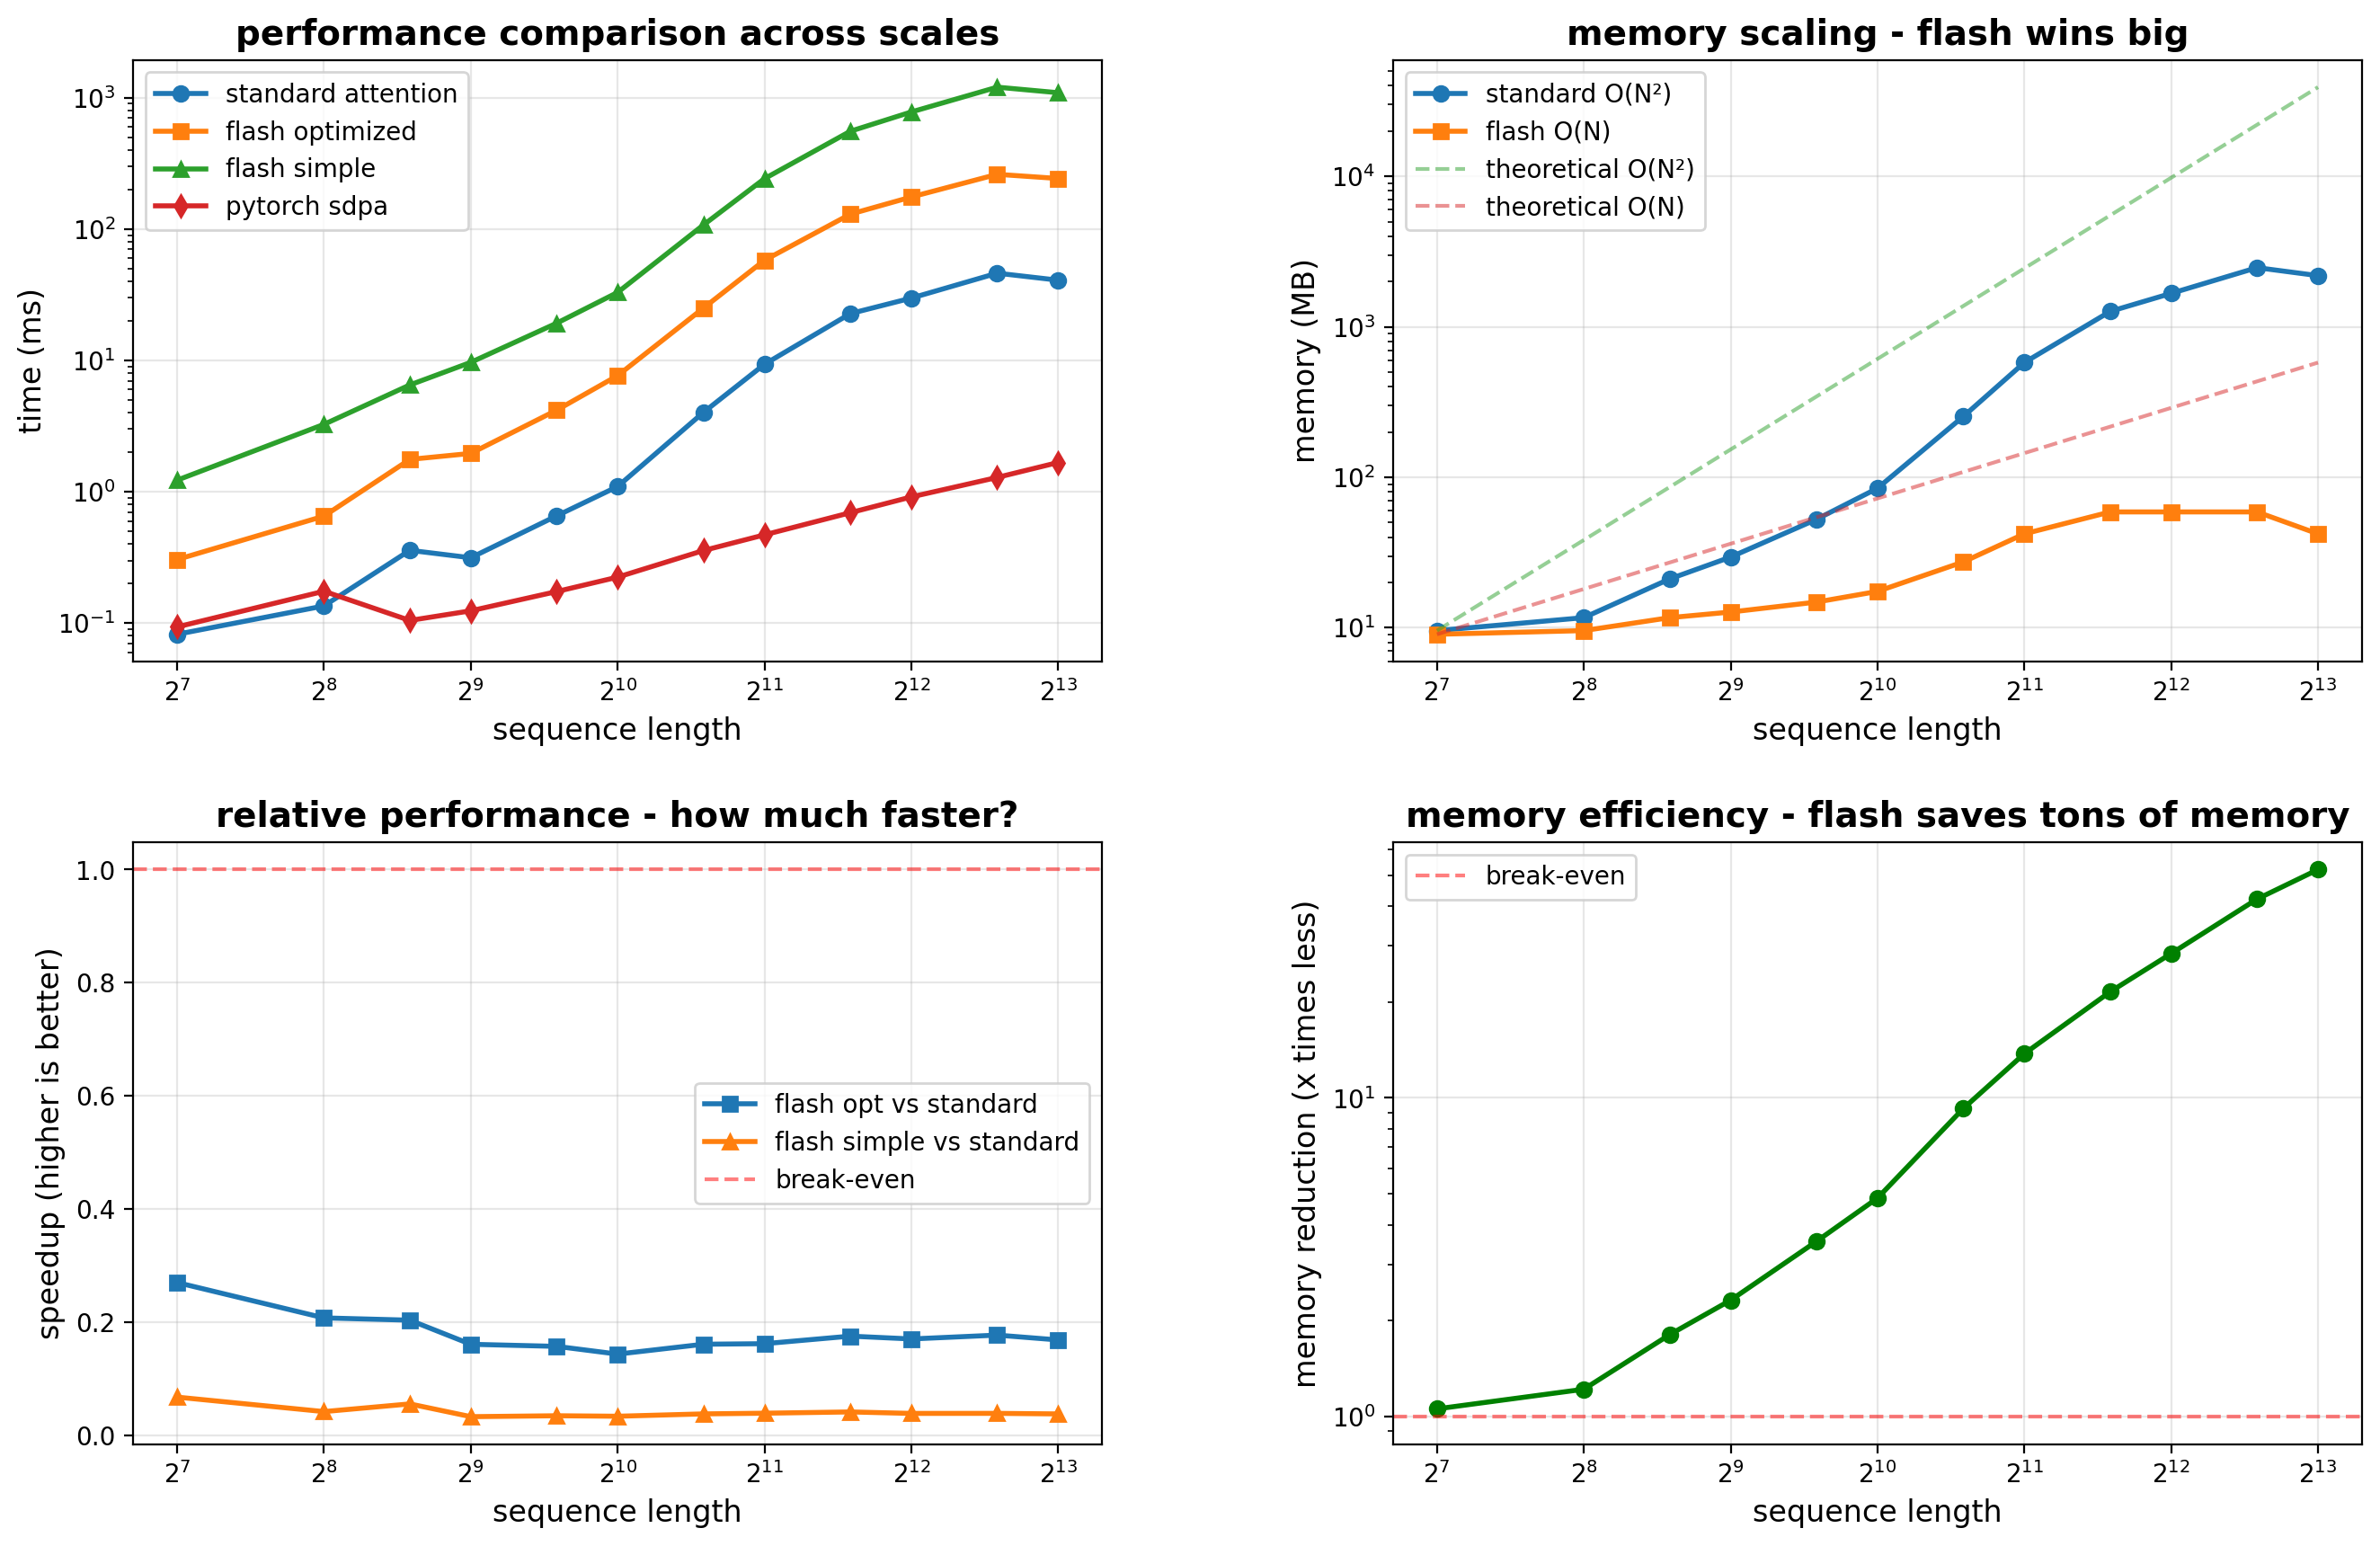

In [18]:
from IPython.display import Image, display
display(Image(filename='flash_attention_large_analysis.png'))